In [1]:
import torch
from IPython import display
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [3]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [4]:
W.shape, b.shape

(torch.Size([784, 10]), torch.Size([10]))

In [5]:
X = torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])
X.sum(axis=0,keepdim=True), X.sum(axis=1,keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [6]:
def softmax(X):
    X_max = X.max(axis=1, keepdim=True)[0] #该函数会返回两个参数，第一个为最值，第二个为最值的索引，因此使用[0]
    X_normalized = X - X_max
    X_exp = torch.exp(X_normalized)
    partition = X_exp.sum(axis=1,keepdim=True)
    return X_exp / partition

In [7]:
X = torch.normal(0, 0.01, size=(2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(tensor([[0.1971, 0.1999, 0.2025, 0.2008, 0.1998],
         [0.2018, 0.2036, 0.1966, 0.1993, 0.1988]]),
 tensor([1., 1.]))

In [8]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]),W)+b) # -1为占位符号，根据后面的W.shape[0]推断-1的值

In [9]:
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [10]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[torch.arange(len(y_hat)), y])
    
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [11]:
def accurary(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [12]:
accurary(y_hat, y) / len(y)

0.5

In [13]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
def evaluate_accurary(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accurary(net(X), y) ,y.numel())
    return metric[0] / metric[1]

In [14]:
evaluate_accurary(net, test_iter)

0.057

In [15]:
def train_epoch_ch3(net, train_iter, loss, updater):
    # 模型设置为训练模式，如果是torch.nn.Moudle的一个实例
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算输出值与损失函数
        y_hat = net(X)
        l = loss(y_hat, y)
        # 更新梯度
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])

        metric.add(float(l.sum()), accurary(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [16]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [17]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1,num_epochs],ylim=[0.3,0.9],
                       legend=['train loss','train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net,train_iter, loss, updater)
        test_acc = evaluate_accurary(net,test_iter)
        animator.add(epoch+1, train_metrics + (test_acc,))
    train_loss , train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1.0 and train_acc > 0.7 ,  train_acc
    assert test_acc <= 1.0 and test_acc > 0.7, test_acc

In [18]:
lr = 0.1
def updater(batch_szie):
    return d2l.sgd([W, b], lr, batch_size)

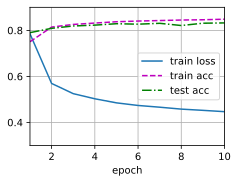

In [19]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

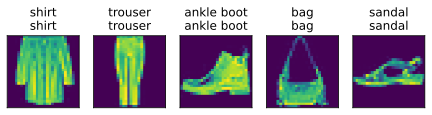

In [20]:
def predict_ch3(net, test_iter, n = 5):
    i = 0
    for X, y in test_iter:
        i += 1
        if i >= 3:
            break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n'+ pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n,28,28)), 1, n, titles = titles[0:n]
    )
predict_ch3(net, test_iter)

# 问题解答
1. 问题1：本节直接实现了基于数学定义softmax运算的softmax函数。这可能会导致什么问题？提示：尝试计算exp(50)的大小
因为$\exp$的定义域范围为$(-\infty,\infty)$，当$z_i$的值趋于无穷大时，$exp$的值可能超出浮点数表示范围，发生数值上溢；当$z_i$的值趋于无穷小时，发生数值上溢，会损失精度。
采用归一化 \
$z_i= z_i - z_{max}$
2. 本节中的函数cross_entropy是根据交叉熵损失函数的定义实现的。它可能有什么问题？提示：考虑对数的定义域
当y的值趋于0时，log的值趋于$-\infty$，发生数值下溢，精度损失 \
给y加上一个无穷小量$\epsilon$ \
3.